# Introduction

The code that follows deploys an ensemble learner comprising of a random forest classifier and a multi-layer neural network classifier to identify the likelihood of machine failures given a set of variable points associated with the machine and its environment

This code was built and run within the kaggle ecosystem for the kaggle challenge named **Binary Classification of Machine Failures** (https://www.kaggle.com/competitions/playground-series-s3e17/overview). Also, a tabular learner neural network from the fastai library was used to train the dataset and validate the results.

This approach is inspired from my learnings as a part of the fastai online training sessions. To test this file, you can open the challenge link, start a notebook and paste this code

# Data Ingestion and Quick Exploratory Analysis

1. What follows is a standard startup code snippet found across all Kaggle notebooks

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


2. Import all the required libraries. Please note the presence of fastai library in order to generate a neural network based tabular learner

In [2]:
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from fastai.tabular.all import *
from sklearn.metrics import accuracy_score

In [3]:
path = Path('/kaggle/input/playground-series-s3e17')
! ls {path}

sample_submission.csv  test.csv  train.csv


3. Read the training and test data sets along with capturing a quick snapshot of the value distribution across different predictors

In [4]:
train_df = pd.read_csv(path/'train.csv',low_memory=False)
test_df = pd.read_csv(path/'test.csv',low_memory=False)
train_df.nunique()

id                         136429
Product ID                   9976
Type                            3
Air temperature [K]            95
Process temperature [K]        81
Rotational speed [rpm]        952
Torque [Nm]                   611
Tool wear [min]               246
Machine failure                 2
TWF                             2
HDF                             2
PWF                             2
OSF                             2
RNF                             2
dtype: int64

4. Detect the presence of missing entries or NaNs amongst the predictor variables

In [5]:
train_df.isna().sum()
test_df.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

The predictor space is fairly clean at this point in time given there are no missing entries

5. The id predictor can be discarded from both the training and test sets as it just represents a unique id for each instance

In [7]:
train_df.drop('id',inplace=True,axis='columns')
test_df.drop('id',inplace=True,axis='columns')

6. It is worthwhile to understand the performance of a null classifier which assumes the predicted class across all training instances to be the most frequently occuring class label

In [8]:
error_rate = train_df['Machine failure'].sum()/train_df['Machine failure'].shape[0]
null_accuracy = 1- error_rate
null_accuracy

0.9842555468412141

The misclassification error would only be 1.58% (98.4% accuracy) even with a null classifier.Hence, it can be seen that the distribution of class labels across the binary categories is unbalanced which requires adapting the training strategy to avoid the associated biases

# Feature Engineering

1. On scrolling through the kaggle forums, the following features (predictors) wrapped in a function were engineered and added to the predictor space for helping improve the accuracy of predictions

In [9]:
def add_new_features(df):
    df['Temperature_difference [K]'] = df['Air temperature [K]'] - df['Process temperature [K]']
    df['Torque_speed_ratio'] =  df['Torque [Nm]']/df['Rotational speed [rpm]']
    df['Energy'] = df['Rotational speed [rpm]']*df['Torque [Nm]']
    df['Wear_rate'] = df['Tool wear [min]'] / df['Rotational speed [rpm]']
    return df

train_df = add_new_features(train_df)

It is a good practice to ensure that missing values are not introduced as NaNs when defining new predictors. On a quick check, it can be seen that irregularities are not introduced in the training data through addition of new predictors

In [10]:
train_df.isna().sum()

Product ID                    0
Type                          0
Air temperature [K]           0
Process temperature [K]       0
Rotational speed [rpm]        0
Torque [Nm]                   0
Tool wear [min]               0
Machine failure               0
TWF                           0
HDF                           0
PWF                           0
OSF                           0
RNF                           0
Temperature_difference [K]    0
Torque_speed_ratio            0
Energy                        0
Wear_rate                     0
dtype: int64

A similar test can be performed on the test data to ensure that missing values do not surface during feature engineering

In [11]:
test_df = add_new_features(test_df)
test_df.isna().sum()

Product ID                    0
Type                          0
Air temperature [K]           0
Process temperature [K]       0
Rotational speed [rpm]        0
Torque [Nm]                   0
Tool wear [min]               0
TWF                           0
HDF                           0
PWF                           0
OSF                           0
RNF                           0
Temperature_difference [K]    0
Torque_speed_ratio            0
Energy                        0
Wear_rate                     0
dtype: int64

2. Additional sanitization can be performed by eliminating duplicate entries from the training dataset

In [12]:
dup_instances = train_df.duplicated()
if dup_instances.value_counts()[1]>0: train_df.drop_duplicates(inplace=True)

# Identifying Significant predictors through a random forest classifier

This section involves creation of a tabular data structure using the fastai library and then extracting the training and validation sets from the structure for training a random forest classifier. The goal at this stage is not to predict the likelihood of machine failure, but to identify the top predictors in the predictor space in terms of association with the failure event

1. The predictors are identified as being continuous vs. categorical as fastai tabular dataloader requires this piece of information. The cont_cat_split function from the fastai library is used for this purpose which results in the names of continuous predictors being stored in cont_names and the names of categorical predictors being stored in cat_names

In [13]:
dep_var = 'Machine failure'
train_df['Product ID'] = train_df['Product ID'].astype('category')
cont_names,cat_names = cont_cat_split(train_df,dep_var = dep_var)

2. A tabular pandas object is created by leveraging the fastai library while subjecting the features to categorification. It should be noted that stratified sampling is used for achieving the split between the training and validation sets so that the ratio of failure and non-failure samples is consistent across the training and validation sets

In [14]:
tp = TabularPandas(train_df,procs=[Categorify],cont_names=cont_names,cat_names=cat_names,
                   y_names=dep_var,
                   splits=TrainTestSplitter(test_size=0.25,stratify=train_df[dep_var].to_list())(range_of(train_df)))

3. The training and validation data sets from the tabular pandas object are used to train a random forest classifier on the predictor space

In [15]:
train_x,train_y = tp.train.xs,tp.train.y
valid_x,valid_y = tp.valid.xs,tp.valid.y

3. The model creation and training processes are wrapped in a function for reusability in the later sections. The **RandomForestClassifier class from the scikit-learn library** has been used here. It should be noted that the **'class weight' parameter is set to 'balanced'** so that the model does not get biased towards the excessive presence of non-failure class labels in the training set. The accuracy calculation is also wrapped in a function for reusability

In [16]:
def rf(xs,y,n_estimators=200,min_samples_leaf=20,max_features='sqrt',max_samples=0.7):
    return RandomForestClassifier(n_jobs=-1,n_estimators=n_estimators,max_features=max_features,max_samples=max_samples,
                                  min_samples_leaf=min_samples_leaf,oob_score=True,class_weight='balanced').fit(xs,y)

def m_accuracy(m,xs,y): return accuracy_score(y,m.predict(xs))

4. The RandomForestClassifier is trained on the training data and the **performance is evaluated** based on **accuracy determined for the validation set and the out-of-bag training samples** corresponding to the decision tree ensemble

In [17]:
m = rf(train_x,train_y)
print(f'Accuracy:{m_accuracy(m,valid_x,valid_y)},OOB estimation score:{m.oob_score_}')

Accuracy:0.9875532166508988,OOB estimation score:0.9861044042140119


It can be seen that the random forest model generates a higher accuracy compared to a null classifier. **Filtering out the weaker predictors** can **reduce model overfitting** and further improve the prediction accuracy

5. The **importance score** associated with each predictor can be identified using the **imp_scores function** post which the predictors with the least importance scores can be filtered out

<Axes: xlabel='features', ylabel='importance score'>

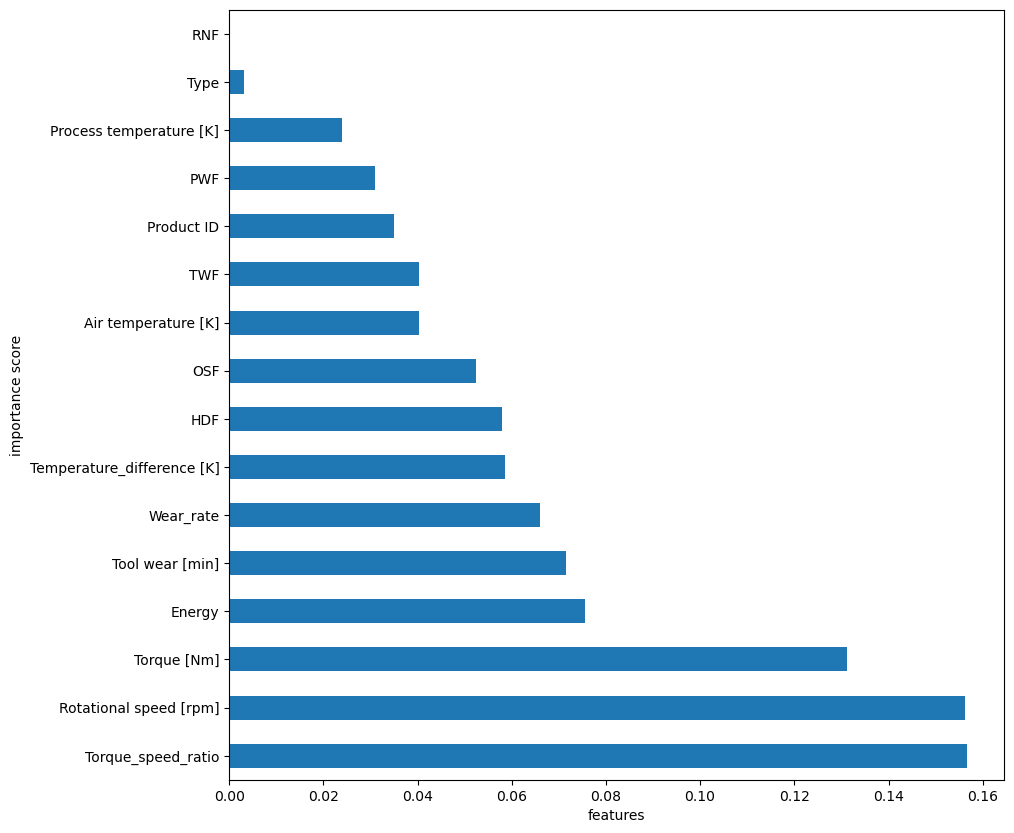

In [18]:
def imp_scores(df,m):
    return pd.DataFrame({'col':df.columns,'imp score':m.feature_importances_}).sort_values('imp score',ascending=False)

importance = imp_scores(train_x,m)
importance.plot('col','imp score','barh',xlabel='features',ylabel='importance score',legend=False,figsize=(10,10))

In [19]:
importance

,col,imp score
13,Torque_speed_ratio,0.156721
9,Rotational speed [rpm],0.156208
10,Torque [Nm],0.131123
14,Energy,0.075569
11,Tool wear [min],0.071626
15,Wear_rate,0.066081
12,Temperature_difference [K],0.058608
3,HDF,0.058028
5,OSF,0.052389
7,Air temperature [K],0.040282


6. The predictors with importance score of >0.03 could be retained for future model fitting which will result in selection of ~top 80 %ile of predictors to reduce the possibility of overfitting

In [20]:
best_predictors = importance[importance['imp score']>0.03].col.to_list()
best_predictors

['Torque_speed_ratio',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Energy',
 'Tool wear [min]',
 'Wear_rate',
 'Temperature_difference [K]',
 'HDF',
 'OSF',
 'Air temperature [K]',
 'TWF',
 'Product ID',
 'PWF']

# Random Forest Classifier prediction on the selected best predictors

1. Identify validation set prediction accuracy and out-of-bag prediction accuracy with the random forest classifier trained on a predictor space consisting of only the best predictors identified in the previous section

In [21]:
train_x_best, valid_x_best = tp.train.xs[best_predictors],tp.valid.xs[best_predictors]
m_best_pred = rf(train_x_best,train_y)
print(f'Accuracy:{m_accuracy(m_best_pred,valid_x_best,valid_y)},OOB estimation score:{m_best_pred.oob_score_}')

Accuracy:0.9869027909176916,OOB estimation score:0.985128755999251


The classification accuracy more or less stays the same as that of the full predictor space,hence the best predictors determined in the previous section can be used in the training iterations henceforth to foreclose any possibility of model overfitting

# Neural network classifier prediction on the selected best predictors

1. A separate set of **training and validation datasets consisting of only identified best predictors** from the previous sections could be used to train a **neural network classifier**. The continuous and categorical columns can be extracted at this step as well

In [22]:
dep_var_nn = 'Machine failure'
train_df_nn, test_df_nn = train_df[best_predictors+[dep_var_nn]],test_df[best_predictors]
cont_nn,cat_nn = cont_cat_split(train_df_nn,dep_var=dep_var_nn)

2. A **tabular dataloader** to feed the training and validation data into a fastai neural network learner can be created at this stage from a tabular pandas object that was used earlier. A couple of quick callouts here:
    * The **predictors should be subjected to normalization** for training a neural network as the model is sensitive to the relative scale variation across predictors
    * A **batch of 1024** has been selected for each training step of the neural network in an epoch

In [23]:
tp_dl = TabularPandas(train_df_nn,procs=[Categorify,Normalize],cont_names = cont_nn,cat_names=cat_nn,y_names=dep_var_nn,
                     splits=TrainTestSplitter(test_size=0.25,stratify=train_df_nn[dep_var].to_list())(range_of(train_df_nn)),
                      y_block=CategoryBlock()).dataloaders(bs=1024,path=".")
tp_dl.show(3)

,HDF,OSF,TWF,Product ID,PWF,Torque_speed_ratio,Rotational speed [rpm],Torque [Nm],Energy,Tool wear [min],Wear_rate,Temperature_difference [K],Air temperature [K],Machine failure
33569,0,0,0,L48364,0,0.031730,1497.0,47.500000,71107.500000,27.0,0.018036,-11.1,297.299988,0
84137,0,0,0,L47938,0,0.022431,1596.0,35.799999,57136.800781,231.0,0.144737,-11.2,296.799988,0
84000,0,0,0,L53939,0,0.029612,1496.0,44.299999,66272.796875,208.0,0.139037,-9.3,301.700012,0


3. A tabular learner built using fastai library can set up the neural network architecture for fine tuning to the task of machine failure likelihood prediction. The layers argument can be experimented with further to achieve higher accuracy on the validation set

In [24]:
learner = tabular_learner(tp_dl,layers=[256,128],metrics=accuracy)

4. The fastai library has a function through which the learning rate can be determined for the various training steps

SuggestedLRs(slide=0.05754399299621582, valley=0.0008317637839354575)

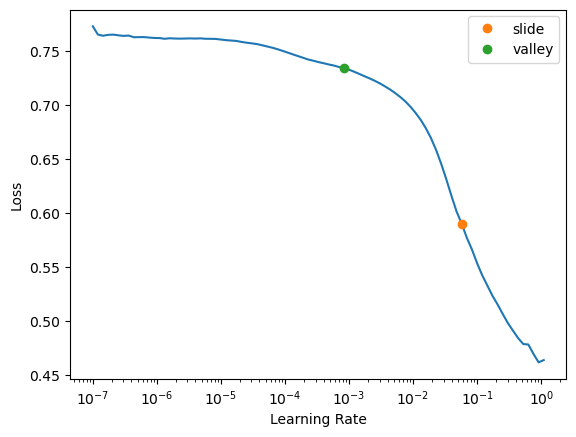

In [25]:
learner.lr_find(suggest_funcs=(slide,valley))

5. The model is trained with a weight decay parameter (wd) for regularization to prevent overfitting. The learning rate corresponding to the slide data point can be used for fine-tuning the model

In [26]:
learner.fit_one_cycle(5,1e-1,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.096087,0.025437,0.995802,00:06
1,0.030602,0.030144,0.993525,00:06
2,0.019975,0.022121,0.995654,00:06
3,0.014881,0.023380,0.995713,00:06
4,0.010794,0.027622,0.995684,00:06


The model accuracy is much better than that seen with the random forest classifier. Hence, an ensemble of predictions from both the models can also be experimented with

# Ensembling predictions from the random forest classifier and the neural network learner along with testing the same on the validation data set

1. A new random forest classifier is trained on a similar predictor space as that supplied to the neural network classifier (tabular learner) to ensure that the same validation set can be used for model performance ensembling of both the approaches. The ensemble predictions accuracy of failure likelihood from both the approaches can be determined at this point in time

In [27]:
tp_rf = TabularPandas(train_df_nn,procs=[Categorify],cont_names = cont_nn,cat_names=cat_nn,y_names=dep_var_nn,
                     splits=TrainTestSplitter(test_size=0.25,stratify=train_df_nn[dep_var].to_list())(range_of(train_df_nn)),
                      ).dataloaders(path=".")
m_rf = rf(tp_rf.train.xs,tp_rf.train.y)
rf_prob = m_rf.predict_proba(tp_rf.valid.xs)
tl_probs,_ = learner.get_preds(dl=learner.dls.valid)
ensemble_prob = (rf_prob[:,1]+to_np(tl_probs[:,1].squeeze()))/2
accuracy_score(learner.dls.valid.y,np.where(ensemble_prob>0.5,1,0))

0.9958609271523179

It can be seen that the accuracy score computed on the validation data set for the ensemble is better than that of the null classifier or that of the individual classifier models

# Training the model on the entire training data set

1. Before being applied on a test/holdout set, the ensemble model that has now been validated for returning the best accuracy can be trained on the entire training dataset

In [28]:
tp_full_rf = TabularPandas(train_df_nn,procs=[Categorify],cont_names = cont_nn,cat_names=cat_nn,y_names=dep_var_nn,
                     splits=MaskSplitter([False]*train_df_nn.shape[0])(range_of(train_df_nn))).dataloaders(path='.')
tp_full_nn = TabularPandas(train_df_nn,procs=[Categorify,Normalize],cont_names = cont_nn,cat_names=cat_nn,y_names=dep_var_nn,
                     splits=MaskSplitter([False]*train_df_nn.shape[0])(range_of(train_df_nn)),
                      y_block=CategoryBlock()).dataloaders(bs=1024,path=".")
rf_full = rf(tp_full_rf.train.xs,tp_full_rf.train.y)
learner_full = tabular_learner(tp_full_nn,layers=[256,128])
learner_full.fit_one_cycle(5,1e-1,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.059864,None,00:07
1,0.023329,None,00:07
2,0.018515,None,00:07
3,0.015100,None,00:07
4,0.011081,None,00:07


/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


2. A method like the one shown below can be used to apply the latest fine-tuned model on a test/holdout data set and return a data frame of the likelihood predictions

In [29]:
def create_submission_ensemble(rf_m,rf_tp,learner):
    final_test_df = pd.read_csv(path/'test.csv',low_memory=False)
    test_dls_nn = learner.dls.test_dl(test_df_nn)
    preds_nn,_ = learner.get_preds(dl=test_dls_nn)
    test_dls_rf = rf_tp.test_dl(test_df_nn)
    preds_rf = rf_m.predict_proba(test_dls_rf.xs)
    ensemble_pred = (preds_rf[:,1] + to_np(preds_nn[:,1].squeeze()))/2
    final_test_df['Machine failure'] = ensemble_pred
    subm = final_test_df[['id','Machine failure']]
    return subm